## Glued Trees Annotated Tutorial Notebook
This notebook is meant to be a guide explaining the code of the glued trees algorithm in Classiq, including the creation and preparation of the Pauli list from the Hamiltonian modeling the system of oscillators representing the columns of the glued trees structure and the creation and execution of the corresponding quantum circuit. To read more about the problem, process, and theory behind the code, check out the README file attached to the repository.

The notebook is used in conjunction with the `pauli_list.cache` file which saves generated Pauli lists as a binary file of raw data. The `generate_pauli_list.py` and `approximate_pauli_list.py` files are used to populate the cache.

In [1]:
from typing import cast
from functools import wraps
from classiq import *
from classiq.execution import ExecutionPreferences
from qiskit.quantum_info import SparsePauliOp
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import pickle

The following code segment contains all of the helper methods that relate to creating the matrix $-\sqrt{\mathbf{A}}$ where
$$
\mathbf{A} = \begin{bmatrix}
3 & -\sqrt{2} & 0 & 0 & 0 & 0 & \cdots & 0 \\
-\sqrt{2} & 3 & -\sqrt{2} & 0 & 0 & 0 & \cdots & \vdots\\
\vdots & \ddots & \ddots & \ddots & 0 & 0 & \cdots & \vdots \\
0 & \cdots & -\sqrt{2} & 3 & -2 & \cdots & 0 & 0 \\
0 & 0 & \cdots & -2 & 3 & -\sqrt{2} & \cdots & 0 \\
\vdots & \cdots & 0 & 0 & \ddots & \ddots & \ddots & \vdots \\
\vdots & \cdots & 0 & 0 & 0 & -\sqrt{2} & 3 & -\sqrt{2} \\
0 & \cdots & 0 & 0 & 0 & 0 & -\sqrt{2} & 3
\end{bmatrix}
$$
and processing it in a form that Classiq's `exponentiation_with_depth_constraint` function can understand.

The `pauli_str_to_enums` and `pauli_list_to_hamiltonian` functions are taken from the Classiq documentation and convert the list of tuples input into a `PauliTerm` list, the input Classiq recognizes for its exponentiation function. The `cache` decorator function simply checks if values are present in the cache and uses them if possible instead of performing a new Pauli list calculation. The caching is important because Pauli decomposition of the matrix is very inefficient, with time complexity $\mathcal{O}(4^n)$.

The `pauli_str` function is the main function used to generate the matrix $-\sqrt{\mathbf{A}}$ and its corresponding Pauli list. The matrix $\mathbf{A}$ is first created as a list of lists and then converted into a numpy array. The `linalg.sqrtm` function from scipy is used to take the square root of the matrix. Then, the `SparsePauliOp.from_operator` function from Qiskit is used to perform Pauli decomposition on the matrix. Finally, the result is converted from Qiskit's Pauli list format to a list of tuples where the first term is the Pauli string and the second term is the coefficient.

All Pauli list outputs are cropped so they have no more than the 200 terms with the largest magnitude. This is to ensure that the circuit depth is at a reasonable range (low thousands) given the limits of current quantum hardware. As a result of this approach, as the number of qubits increases, the accuracy of the Pauli list in comparison to the matrix it represents diminishes so the circuit depth remains roughly constant.

In [2]:
CHAR_TO_STUCT_DICT = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}

def pauli_str_to_enums(pauli):
    return [CHAR_TO_STUCT_DICT[s] for s in pauli]

def pauli_list_to_hamiltonian(pauli_list):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_list
    ]

def cache(func):
    func.cache = pickle.load(open('pauli_list.cache', 'rb'))
    @wraps(func)
    def wrapper(dim):
        if dim in func.cache:
            return func.cache[dim]
        func.cache[dim] = func(dim)
        pickle.dump(func.cache, open('pauli_list.cache', 'wb'))
        return func.cache[dim]
    return wrapper

@cache
def pauli_str(dim):
    A = [[0] * 2**dim for _ in range(2**dim)]
    for i in range(2**dim):
        if i >= 1:
            A[i][i-1] = -2 if i == 2**(dim-1) else -np.sqrt(2)
        A[i][i] = 3
        if i < 2**dim-1:
            A[i][i+1] = -2 if i == 2**(dim-1)-1 else -np.sqrt(2)
    A = -np.array(linalg.sqrtm(A))
    c = SparsePauliOp.from_operator(A)
    result = [(str(c.paulis[i]), c.coeffs[i].real) for i in range(len(c))]
    if len(result) <= 200:
        return result
    return sorted(result, key=lambda x: abs(x[1]), reverse=True)[0:200]

As a preliminary test, we begin by using the `n_oscillators` function to simulate our Hamiltonian represented by Pauli strings of length `dim` from $t=0$ to $t=$`maxim` in `step` intervals. The `add_point` inner function is called repeatedly to simulate exponentiation using Classiq's Aer simulator for different time values. The output is a plot of the shots of the state representing the exit column oscillator $\ket{2^q-1}$ where $q$ is the number of qubits, `dim`.

Since the Pauli strings will be of length $q$, the matrix $\mathbf{A}$ must be of size $2^q \times 2^q$. Since we know that $\mathbf{A}$ is also of size $2n \times 2n$, the relationship $n=2^{q-1}$ is formed. This means that the state representing the exit column oscillator can also be thought of as $\ket{2n-1}$.

In [4]:
def n_oscillators(dim, maxim, step):
    pauli_list = pauli_str(dim)
    def add_point(t):
        @qfunc
        def main(state: Output[QArray[QBit]]) -> None:
            allocate(len(pauli_list[0][0]), state)
            exponentiation_with_depth_constraint(
                pauli_operator=pauli_list_to_hamiltonian(pauli_list),
                evolution_coefficient=t,
                max_depth=2000,
                qbv=state,
            )
        execution_preferences = ExecutionPreferences(num_shots=4096)
        model = set_execution_preferences(create_model(main), execution_preferences)
        quantum_program = synthesize(model)
        job = execute(quantum_program)
        results = job.result()
        return results[0].value
    times = np.arange(0, maxim, step)
    output = []
    for t in times:
        point = add_point(t)
        try:
            index = [idx for idx, s in enumerate(point.parsed_counts) if str(2**dim-1)+'.0' in str(s)][0]
            output.append(point.parsed_counts[index].shots/point.num_shots)
        except IndexError:
            output.append(0)
    plt.plot(times, output)
    plt.xlabel("Time (s)")
    plt.ylabel("Proportion of |"+str(2**dim-1)+"> shots")
    plt.show()

This is an example of the `n_oscillators` function, simulating the proportion of $\ket{7}$ shots for 3 qubits ($n=4$) from $t=0$ to $t=16$ in 1 second intervals. The important thing to note is that there is a spike at $t \approx 2n=8$. A spike should be expected for all states laggingly, starting with $\ket{0}$ at $t \approx 0$, as the initial push of the first ball in the system of balls and springs propagates throughout the system until it reaches the last ball.

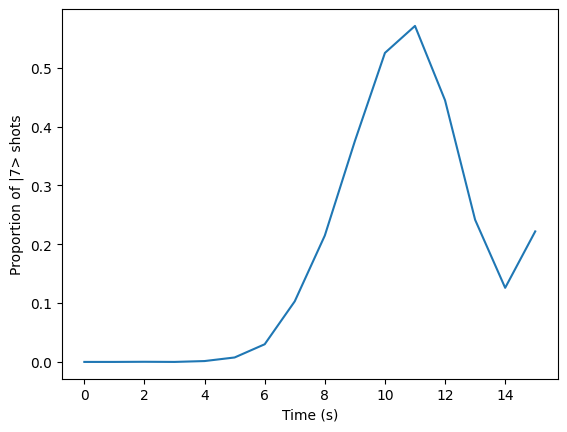

In [43]:
n_oscillators(3, 16, 1)

This is an example of the function, this time simulating the proportion of $\ket{15}$ shots for 4 qubits ($n=8$) from $t=0$ to $t=24$ in 1 second intervals. Once again, as expected, there is a spike at $t \approx 2n=16$.

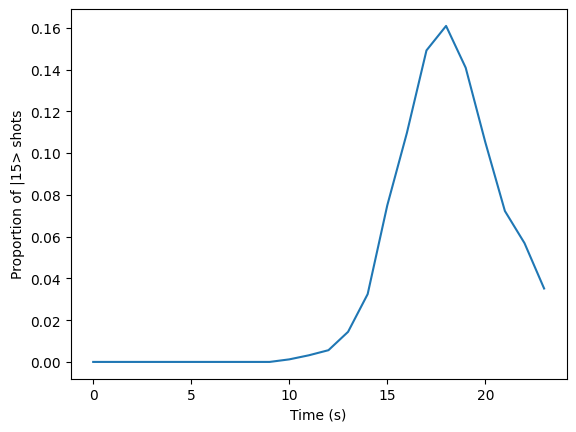

In [44]:
n_oscillators(4, 24, 1)

We are now ready to run our main function, `run_point`. This function takes in the number of qubits `dim` and the time `t` to perform Hamiltonian simulation $\exp(-iHt)$ where $H=-\sqrt{\mathbf{A}}$ using the `exponentiation_with_depth_constraint` function in the Classiq software development kit. 

The `max_depth` parameter is set to 1400, but most quantum circuits generated by the function will have depths in the 1200s, which is around the range of the current limit for comprehensible results in state of the art trapped ion quantum computers. The `num_shots` parameter is set to 8192 to give enough of room for significant spikes in a state to be apparent given the high number of total possible states.

In [3]:
def run_point(dim, t):
    pauli_list = pauli_str(dim)
    @qfunc
    def main(state: Output[QArray[QBit]]) -> None:
        allocate(len(pauli_list[0][0]), state)
        exponentiation_with_depth_constraint(
            pauli_list_to_hamiltonian(pauli_list),
            evolution_coefficient=t,
            max_depth=1400,
            qbv=state,
        )
    execution_preferences = ExecutionPreferences(num_shots=8192)
    model = set_execution_preferences(create_model(main), execution_preferences)
    quantum_program = synthesize(model)
    execute(quantum_program)

In [4]:
run_point(10, 2**10-20)
run_point(10, 2**10-10)
run_point(10, 2**10)
run_point(10, 2**10+10)
run_point(10, 2**10+20)